In [1]:
import numpy as np
import os
import random
import torch

from torch.utils.data import DataLoader, random_split
from torchvision import transforms

from Callbacks import EarlyStopping
from TransferLearningModel import TransferLearningModel
from utils import DicomCoarseDataset3D

In [2]:
BASE_DIR = "C:/Users/Dominik Hahn/OneDrive/Studium/Master/Masterarbeit/Daten"
# BASE_DIR = "C:/Users/domin/OneDrive/Studium/Master/Masterarbeit/Daten"
seed = 41
batch_size = 32
image_size = 80 #best yet 80 with 87%
classes = ["nodule", "non-nodule"]
train_ratio = 0.6

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

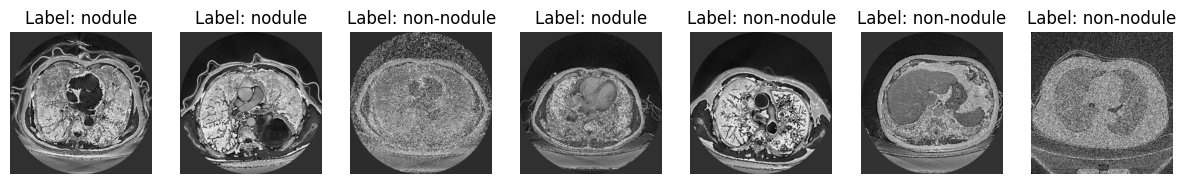

In [3]:
dataset = DicomCoarseDataset3D(root_dir=BASE_DIR, num_images_per_class=len(os.listdir(os.path.join(BASE_DIR, "nodule"))), classes=classes, scenario=1)
# dataset = DicomCoarseDataset3D(root_dir=BASE_DIR, num_images_per_class=100, classes=classes, scenario=1)
dataset.visualize_volumes(num_volumes=7)

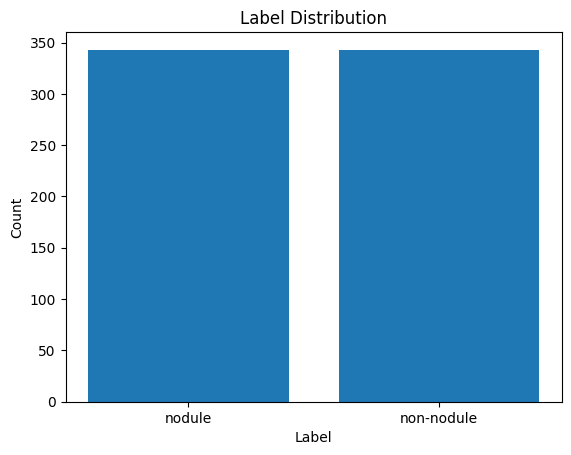

In [4]:
dataset.display_label_distribution()

In [5]:
train_size = int(train_ratio * len(dataset))
val_size = int(((1-train_ratio)/2) * len(dataset)) 
test_size = len(dataset) - train_size - val_size

print(f"Train size: {train_size} --- Validation size: {val_size} --- Test size: {test_size}")

Train size: 411 --- Validation size: 137 --- Test size: 138


In [6]:
print("Processing model: 3D-CNN")
model = TransferLearningModel(classes, "3dcnn")

# Ensure transforms are correctly applied based on model requirements
model.train_transforms, model.test_transforms = model.get_transforms()
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Apply specific transforms to each subset
train_dataset.dataset.transform = model.train_transforms
val_dataset.dataset.transform = model.test_transforms
test_dataset.dataset.transform = model.test_transforms

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize early stopping
early_stopping = EarlyStopping(patience=10)

# Train the current model
model.train(train_loader, val_loader, early_stopping, epochs=1)

Processing model: 3D-CNN
Weights already exist, start from best previous values.
Epoch 1/1 ----- Loss: 0.0042, Accuracy: 99.76% ----- Validation Loss: 0.1163, Validation Accuracy: 95.62%


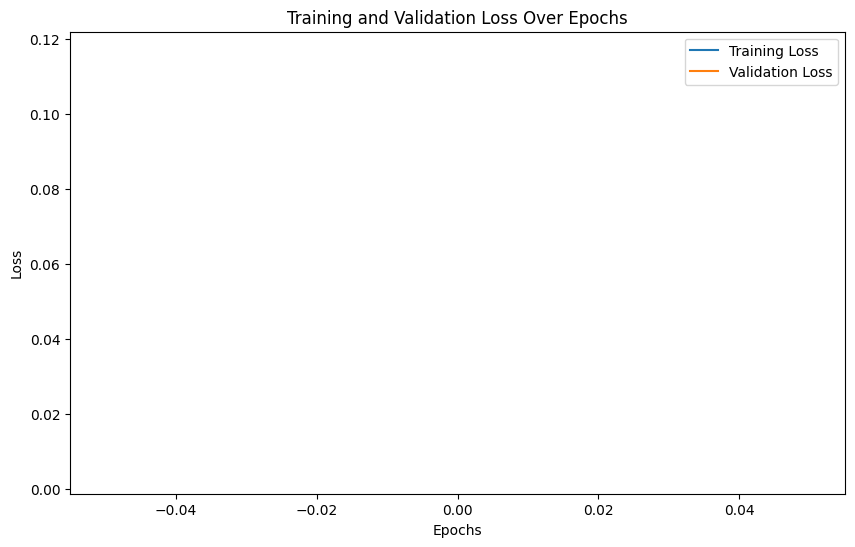

In [7]:
model.plot_loss()

0.026556274496753067
tensor([[ -8.6734,   7.5078],
        [ -6.0350,   5.2660],
        [  7.8800,  -6.6756],
        [  4.4878,  -3.6301],
        [ -4.9290,   4.6074],
        [ -8.4349,   7.0094],
        [ -0.1859,   0.4039],
        [ -3.5377,   3.3850],
        [  5.9769,  -5.0954],
        [  6.5833,  -5.5671],
        [  7.1717,  -6.3097],
        [ -5.2379,   4.8247],
        [ -5.3716,   3.7655],
        [ -5.3941,   4.9330],
        [  5.1873,  -4.4088],
        [  4.2631,  -3.1940],
        [ -4.5375,   3.9739],
        [  7.9384,  -6.9414],
        [ -6.0270,   5.3760],
        [  6.0549,  -5.1842],
        [ -5.9998,   5.2742],
        [  4.1152,  -3.4012],
        [ -1.1321,   0.7952],
        [ -4.0760,   3.9325],
        [ -5.6454,   4.8475],
        [  6.0775,  -5.1298],
        [  5.0273,  -4.0817],
        [  4.3312,  -4.0506],
        [ -5.7173,   5.5543],
        [  7.8702,  -6.3130],
        [ -6.0167,   4.7009],
        [-10.7004,  10.5263]], device='cuda:0')
t

<Figure size 1000x800 with 0 Axes>

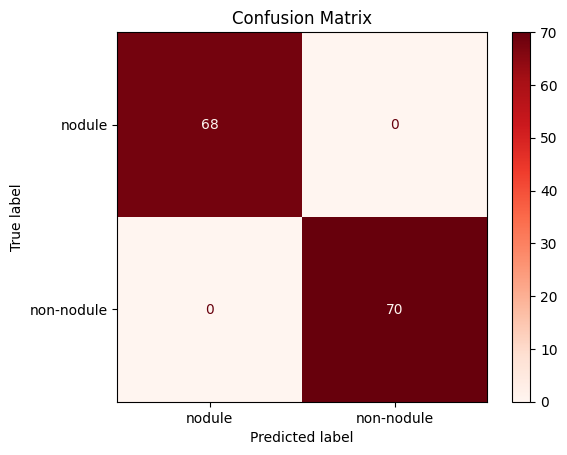

In [8]:
checkpoint = torch.load(f"weights/{model.model_name}.pt", weights_only=False)
model.model.load_state_dict(checkpoint['model_state_dict'])
loss = checkpoint["loss"]
print(loss)
model.evaluate(test_loader)